In [21]:
%pip install rware
%pip install imageio

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [22]:
import gymnasium as gym
import rware

import gymnasium as gym
import rware

import random
import pickle
import time
from collections import defaultdict, deque
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import imageio
from pyglet import image
from tqdm.auto import trange



In [23]:
layout_schedule = [
    ("small", """
..g..
.x.x.
.x.x.
.x.x.
""", 4000),
    ("small_shift_left", """
.g...
x.x..
x.x..
x.x..
""", 2000),
    ("small_shift_right", """
...g.
..x.x
..x.x
..x.x
""", 2000),
]

In [24]:
# =============================================================================
# 2. “ALGORITHM‐AGNOSTIC” HYPERPARAMETERS
#      – These do not change when you swap DQN ↔ Q‐table
# =============================================================================

n_agents           = 2
n_actions          = 5
gamma              = 0.95
epsilon_start       = 1.0
epsilon_min         = 0.05
epsilon_decay       = 0.9995
max_steps_per_ep    = 175

# For DQN (used only if DQNTrainer is active):
learning_rate       = 0.001
batch_size          = 64
target_update_freq  = 10
replay_capacity     = 10000

device = None
try:
    import torch
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"GPU available; DQN‐mode will run on {device}")
except ImportError:
    print("PyTorch not found; only Q‐table mode will work.")

GPU available; DQN‐mode will run on cpu


In [25]:
# =============================================================================
# 3a. DQN NETWORK & AGENT (only used if you call DQNTrainer)
# =============================================================================

if device is not None:
    import torch
    import torch.nn as nn
    import torch.optim as optim

    class DQN(nn.Module):
        def __init__(self, input_dim, output_dim):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, 64),
                nn.ReLU(),
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.Linear(64, output_dim)
            )

        def forward(self, x):
            return self.net(x)

    class DQNAgent:
        def __init__(self, agent_id, policy_net, target_net, optimizer, memory, env):
            self.id = agent_id
            self.policy_net = policy_net
            self.target_net = target_net
            self.optimizer = optimizer
            self.memory = memory
            self.env = env

        def select_action(self, obs, eps):
            if random.random() < eps:
                return self.env.action_space[self.id].sample()
            obs_tensor = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                q_values = self.policy_net(obs_tensor)
            return int(q_values.argmax().item())

        def store_transition(self, state, action, reward, next_state, done):
            self.memory.append((state, action, reward, next_state, done))

        def train_step(self):
            if len(self.memory) < batch_size:
                return None
            batch = random.sample(self.memory, batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)

            states      = torch.tensor(np.array(states), dtype=torch.float32, device=device)
            actions     = torch.tensor(np.array(actions), dtype=torch.long, device=device).unsqueeze(1)
            rewards     = torch.tensor(np.array(rewards), dtype=torch.float32, device=device)
            next_states = torch.tensor(np.array(next_states), dtype=torch.float32, device=device)
            dones       = torch.tensor(np.array(dones), dtype=torch.float32, device=device)

            q_values = self.policy_net(states).gather(1, actions).squeeze()

            with torch.no_grad():
                max_next_q = self.target_net(next_states).max(dim=1)[0]
                td_target = rewards + gamma * max_next_q * (1.0 - dones)

            loss = nn.MSELoss()(q_values, td_target)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            return loss.item()

    def flatten_observations(obs_tuple):
        return [np.array(o).flatten() for o in obs_tuple]

    def train_on_layout_dqn(layout_name, layout_string, num_episodes,
                             agents, shared_policy_net, shared_target_net):
        """
        Train DQN‐agents for num_episodes on the given layout.
        Returns (shared_policy_net, shared_target_net, agents, episode_rewards_log).
        """
        env = gym.make("rware:rware-tiny-2ag-v2", layout=layout_string)

        # Infer obs_dim on first call
        obs, _ = env.reset()
        obs_flat0 = np.array(obs[0]).flatten()
        obs_dim = obs_flat0.shape[0]

        if shared_policy_net is None:
            shared_policy_net = DQN(obs_dim, n_actions).to(device)
            shared_target_net = DQN(obs_dim, n_actions).to(device)
            shared_target_net.load_state_dict(shared_policy_net.state_dict())

        # Assign env & networks to each agent
        for ag in agents:
            ag.env = env
            ag.policy_net = shared_policy_net
            ag.target_net = shared_target_net

        epsilon = epsilon_start
        episode_rewards_log = []

        for episode in trange(
            num_episodes, desc=f"DQN on '{layout_name}'", leave=False
        ):
            obs_tuple, _ = env.reset()
            obs_flat = flatten_observations(obs_tuple)
            done = [False] * n_agents
            total_ep_reward = 0.0

            for step in range(max_steps_per_ep):
                actions = [
                    agents[i].select_action(obs_flat[i], epsilon)
                    for i in range(n_agents)
                ]
                next_obs, rewards, terminated, truncated, _ = env.step(actions)
                terminated = (
                    [terminated] * n_agents
                    if isinstance(terminated, bool) else terminated
                )
                truncated = (
                    [truncated] * n_agents
                    if isinstance(truncated, bool) else truncated
                )
                done = [t or tr for t, tr in zip(terminated, truncated)]
                next_obs_flat = flatten_observations(next_obs)

                for i in range(n_agents):
                    state_i      = obs_flat[i]
                    action_i     = actions[i]
                    reward_i     = rewards[i]
                    next_state_i = next_obs_flat[i]
                    done_i       = float(done[i])

                    agents[i].store_transition(state_i, action_i, reward_i, next_state_i, done_i)
                    _ = agents[i].train_step()
                    total_ep_reward += reward_i

                obs_flat = next_obs_flat
                if all(done):
                    break

            epsilon = max(epsilon_min, epsilon * epsilon_decay)
            if (episode + 1) % target_update_freq == 0:
                shared_target_net.load_state_dict(shared_policy_net.state_dict())

            episode_rewards_log.append(total_ep_reward)

        env.close()
        return shared_policy_net, shared_target_net, agents, episode_rewards_log

else:
    # If GPU/PyTorch is not installed, DQN mode is unavailable
    def train_on_layout_dqn(*args, **kwargs):
        raise RuntimeError("DQN mode requires PyTorch; install torch to use train_on_layout_dqn.")

In [26]:
# =============================================================================
# 3a. DQN NETWORK & AGENT  (reward-shaping version)
# =============================================================================
if device is not None:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import numpy as np
    import random
    from collections import deque

    # --- Hyper-parameters that the reward shaper needs ---
    alpha                = learning_rate     # keep naming consistent
    progress_check       = 100               # how often to print
    # (gamma, batch_size, target_update_freq already defined above)

    # -------------------------------------------------------------------------
    # 1) The network
    # -------------------------------------------------------------------------
    class DQN(nn.Module):
        def __init__(self, input_dim, output_dim):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, 64),
                nn.ReLU(),
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.Linear(64, output_dim)
            )

        def forward(self, x):
            return self.net(x)

    # -------------------------------------------------------------------------
    # 2) Enhanced Agent  (includes visited-state tracking)
    # -------------------------------------------------------------------------
    class DQNAgent2:
        def __init__(self, agent_id, policy_net, target_net,
                     optimizer, memory, env):
            self.id         = agent_id
            self.policy_net = policy_net
            self.target_net = target_net
            self.optimizer  = optimizer
            self.memory     = memory            # shared replay deque
            self.env        = env

            # used by the reward-shaping logic
            self.visited_states: set[tuple] = set()

        # ε-greedy
        def select_action(self, obs_flat, eps):
            if random.random() < eps:
                return self.env.action_space[self.id].sample()
            obs_t = torch.tensor(obs_flat, dtype=torch.float32, device=device)
            with torch.no_grad():
                q_vals = self.policy_net(obs_t)
            return int(q_vals.argmax().item())

        # replay-buffer I/O
        def store_transition(self, s_flat, a, r, s_next_flat, done):
            self.memory.append((s_flat, a, r, s_next_flat, done))

        # minibatch update
        def train_step(self):
            if len(self.memory) < batch_size:
                return None
            batch = random.sample(self.memory, batch_size)
            s, a, r, s_next, d = zip(*batch)

            s      = torch.tensor(np.array(s),      dtype=torch.float32, device=device)
            a      = torch.tensor(np.array(a),      dtype=torch.long,    device=device).unsqueeze(1)
            r      = torch.tensor(np.array(r),      dtype=torch.float32, device=device)
            s_next = torch.tensor(np.array(s_next), dtype=torch.float32, device=device)
            d      = torch.tensor(np.array(d),      dtype=torch.float32, device=device)

            q      = self.policy_net(s).gather(1, a).squeeze()
            with torch.no_grad():
                max_next_q = self.target_net(s_next).max(1)[0]
                td_target  = r + gamma * max_next_q * (1.0 - d)

            loss = nn.MSELoss()(q, td_target)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            return loss.item()

    # -------------------------------------------------------------------------
    # 3) Flatten helper
    # -------------------------------------------------------------------------
    def flatten_observations(obs_tuple):
        return [np.array(o).flatten() for o in obs_tuple]

    # -------------------------------------------------------------------------
    # 4) Trainer with full reward-shaping pipeline
    # -------------------------------------------------------------------------
    def train_on_layout_dqn(layout_name, layout_string, num_episodes,
                             agents, shared_policy_net, shared_target_net):

        env = gym.make("rware:rware-tiny-2ag-v2", layout=layout_string)

        # infer obs_dim once
        obs0, _  = env.reset()
        obs_dim  = np.array(obs0[0]).flatten().shape[0]

        # initialise shared nets / optimiser once
        if shared_policy_net is None:
            shared_policy_net  = DQN(obs_dim, n_actions).to(device)
            shared_target_net  = DQN(obs_dim, n_actions).to(device)
            shared_target_net.load_state_dict(shared_policy_net.state_dict())
            shared_optimizer   = optim.Adam(shared_policy_net.parameters(), lr=alpha)
            for ag in agents:
                ag.policy_net = shared_policy_net
                ag.target_net = shared_target_net
                ag.optimizer  = shared_optimizer
        else:
            shared_optimizer = agents[0].optimizer  # already created

        # give every agent the env reference
        for ag in agents:
            ag.env = env

        epsilon        = epsilon_start
        episode_rewards_log = []

        for ep in trange(num_episodes,
                         desc=f"DQN on '{layout_name}'", leave=False):

            obs_tuple, _      = env.reset()
            obs_flat_list     = flatten_observations(obs_tuple)
            for ag in agents:                         # reset visited sets
                ag.visited_states.clear()
                ag.visited_states.add(tuple(obs_flat_list[ag.id]))

            total_reward_raw    = [0.0] * n_agents
            done_flags          = [False] * n_agents
            episode_losses      = []

            # ------------- episode loop -------------
            for step in range(max_steps_per_ep):
                # choose actions
                actions = [agents[i].select_action(obs_flat_list[i], epsilon)
                           for i in range(n_agents)]

                nxt_tuple, rewards, term, trunc, _ = env.step(actions)
                nxt_flat_list = flatten_observations(nxt_tuple)

                if isinstance(term,  bool): term  = [term]  * n_agents
                if isinstance(trunc, bool): trunc = [trunc] * n_agents
                done_flags = [t or tr for t, tr in zip(term, trunc)]

                # --------- per-agent shaping / training -------
                for i in range(n_agents):
                    raw_r   = rewards[i]
                    shaped  = raw_r

                    state_flat      = obs_flat_list[i]
                    nxt_state_flat  = nxt_flat_list[i]
                    state_key       = tuple(state_flat)

                    # (a) revisit penalty
                    if raw_r == 0:
                        if state_key in agents[i].visited_states:
                            shaped -= 0.05
                            if actions[i] in (2, 3):   # idle directions
                                shaped -= 0.005
                        else:
                            agents[i].visited_states.add(state_key)

                    # (b) invalid action (no state change)
                    if np.allclose(state_flat, nxt_state_flat):
                        shaped -= 0.05

                    # (c) delivery bonus
                    if raw_r == 1:
                        shaped += 1
                        if (state_flat[2] > 0.5) and (nxt_state_flat[2] < 0.5):
                            shaped += 0.2

                    # (d) tiny step cost
                    shaped -= 0.005

                    # (e) Euclidean guidance
                    curr = state_flat[0:2]; nxt = nxt_state_flat[0:2]
                    if i == 0:     # compute once per env step
                        valid_shelves = np.array([
                            (int(s.x), int(s.y))
                            for s in env.unwrapped.shelfs
                            if s in env.unwrapped.request_queue
                        ])
                        goals = np.array(env.unwrapped.goals)

                    if state_flat[2] < 0.5 and valid_shelves.size > 0:
                        delta = (np.linalg.norm(valid_shelves - curr, axis=1).min()
                               - np.linalg.norm(valid_shelves - nxt,  axis=1).min())
                        if delta > 0: shaped += 0.05 * delta
                    elif state_flat[2] > 0.5:
                        delta = (np.linalg.norm(goals - curr, axis=1).min()
                               - np.linalg.norm(goals - nxt,  axis=1).min())
                        if delta > 0: shaped += 0.05 * delta
                    # -----------------------------------------------------

                    agents[i].store_transition(state_flat, actions[i],
                                               shaped, nxt_state_flat,
                                               float(done_flags[i]))
                    loss_i = agents[i].train_step()
                    if loss_i is not None:
                        episode_losses.append(loss_i)

                    total_reward_raw[i] += raw_r

                obs_flat_list = nxt_flat_list
                if all(done_flags):
                    break
            # ------------- end episode -------------

            episode_rewards_log.append(sum(total_reward_raw))

            # ε-decay and target-net sync
            epsilon = max(epsilon_min, epsilon * epsilon_decay)
            if (ep + 1) % target_update_freq == 0:
                shared_target_net.load_state_dict(shared_policy_net.state_dict())

            if (ep + 1) % progress_check == 0:
                print(f"Episode {ep+1}, ε={epsilon:.3f}, "
                      f"raw_reward_sum={sum(total_reward_raw):.1f}, "
                      f"avg_loss={np.mean(episode_losses) if episode_losses else 0:.4f}")

        env.close()
        return shared_policy_net, shared_target_net, agents, episode_rewards_log

else:   # device is None
    def train_on_layout_dqn(*args, **kwargs):
        raise RuntimeError("DQN mode requires PyTorch.")


In [27]:
# =============================================================================
# 3b. Q‐TABLE “AGENT” & TRAINER (always available)
# =============================================================================

class QAgent:
    def __init__(self, agent_id, env, Q_ref, alpha=0.1):
        self.id = agent_id
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.Q = Q_ref

    def get_state_key(self, obs):
        return tuple(np.round(obs, 1))

    def select_action(self, obs):
        state = self.get_state_key(obs)
        if random.random() < self.epsilon:
            return self.env.action_space[self.id].sample()
        return int(np.argmax(self.Q[state]))

    def update(self, obs, action, reward, next_obs):
        s      = self.get_state_key(obs)
        s_next = self.get_state_key(next_obs)
        if s_next not in self.Q:
            self.Q[s_next] = np.zeros(n_actions)
        best_next = np.max(self.Q[s_next])
        td_target = reward + self.gamma * best_next
        self.Q[s][action] += self.alpha * (td_target - self.Q[s][action])

    def decay_epsilon(self):
        self.epsilon = max(epsilon_min, self.epsilon * epsilon_decay)

def train_on_layout_qtable(layout_name, layout_string, num_episodes, agents):
    """
    Train Q‐table agents for num_episodes on the given layout.
    Returns (agents, episode_rewards_log).
    """
    env = gym.make("rware:rware-tiny-2ag-v2", layout=layout_string)

    # Replace each agent’s .env with this new env, and reset Q‐tables if first call
    for ag in agents:
        ag.env = env

    episode_rewards_log = []

    for episode in trange(
        num_episodes, desc=f"Q‐table on '{layout_name}'", leave=False
    ):
        obs, _ = env.reset()
        done = [False] * n_agents
        total_ep_reward = [0.0] * n_agents

        for step in range(max_steps_per_ep):
            actions = [agents[i].select_action(obs[i]) for i in range(n_agents)]
            next_obs, rewards, terminated, truncated, _ = env.step(actions)
            terminated = (
                [terminated] * n_agents
                if isinstance(terminated, bool) else terminated
            )
            truncated = (
                [truncated] * n_agents
                if isinstance(truncated, bool) else truncated
            )
            done = [t or tr for t, tr in zip(terminated, truncated)]

            for i in range(n_agents):
                agents[i].update(obs[i], actions[i], rewards[i], next_obs[i])
                total_ep_reward[i] += rewards[i]

            obs = next_obs
            if all(done):
                break

        # Decay each agent's epsilon
        for ag in agents:
            ag.decay_epsilon()

        episode_rewards_log.append(sum(total_ep_reward))

    env.close()
    return agents, episode_rewards_log

In [28]:
# =============================================================================
# 3c.  SHARED-EXPERIENCE ACTOR-CRITIC (SEAC)
# =============================================================================
if device is not None:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import random
    from collections import deque, namedtuple

    SEACBatch = namedtuple("SEACBatch",
                           "s a r s_next done logp_other")

    class SEACNet(nn.Module):
        """Shared π and V head."""
        def __init__(self, input_dim, hidden=128):
            super().__init__()
            self.base = nn.Sequential(
                nn.Linear(input_dim, hidden),
                nn.ReLU(),
                nn.Linear(hidden, hidden),
                nn.ReLU(),
            )
            self.policy_head = nn.Linear(hidden, n_actions)
            self.value_head  = nn.Linear(hidden, 1)

        def forward(self, x):
            h = self.base(x)
            return self.policy_head(h), self.value_head(h).squeeze(-1)

    class SEACAgent:
        """
        One logical agent; all agents *share* the same SEACNet & optimiser.
        Stores its own trajectories so we can compute the “other-agent”
        importance weights.
        """
        def __init__(self, agent_id, net, optim, memory, env):
            self.id      = agent_id
            self.net     = net          # shared
            self.optim   = optim        # shared
            self.memory  = memory       # shared replay deque
            self.env     = env
            self.gamma   = gamma

        # ---------- acting ----------
        def select_action(self, obs, eps=0.0):
            """ε only for evaluation parity; training is on-policy."""
            with torch.no_grad():
                logits, _ = self.net(torch.tensor(obs, dtype=torch.float32,
                                                  device=device))
                probs = torch.softmax(logits, dim=-1).cpu().numpy()
            if random.random() < eps:
                act = self.env.action_space[self.id].sample()
                logp = np.log(1.0 / n_actions)
            else:
                act = int(np.random.choice(n_actions, p=probs))
                logp = np.log(probs[act] + 1e-8)
            return act, logp

        # ---------- store transition ----------
        def store(self, s, a, r, s_next, done, logp_other):
            self.memory.append(
                SEACBatch(s, a, r, s_next, done, logp_other)
            )

    # -----------------------------------------------------------------
    # SEAC trainer: importance-weighted A2C with shared experience
    # -----------------------------------------------------------------
    def train_on_layout_seac(layout_name, layout_string, num_episodes,
                             agents, shared_net):

        env = gym.make("rware:rware-tiny-2ag-v2", layout=layout_string)

        # init shared net / optimiser once
        if shared_net is None:
            obs0, _ = env.reset()
            obs_dim = np.array(obs0[0]).flatten().shape[0]
            shared_net = SEACNet(obs_dim).to(device)
            shared_optim = optim.Adam(shared_net.parameters(), lr=3e-4)
            for ag in agents:
                ag.net   = shared_net
                ag.optim = shared_optim
        else:
            shared_optim = agents[0].optim

        # hyper-params
        entropy_coef   = 0.01
        value_coef     = 0.5
        is_coef        = 1.0
        batch_T        = 32          # roll-out length before an update
        clip_grad_norm = 0.5

        episode_returns = []
        traj_deque = deque(maxlen=batch_T*n_agents)  # short buffer

        for ep in trange(num_episodes,
                         desc=f"SEAC on '{layout_name}'", leave=False):

            obs_tuple, _ = env.reset()
            done_flags   = [False]*n_agents
            ep_return    = 0.0

            while not all(done_flags):
                # --- collect trajectories up to batch_T or episode end ---
                for _ in range(batch_T):
                    flat_obs = [np.array(o).flatten() for o in obs_tuple]
                    actions  = []
                    logps    = []

                    # Each agent picks action; we also keep *all* log-probs
                    for i in range(n_agents):
                        a_i, logp_i = agents[i].select_action(flat_obs[i])
                        actions.append(a_i); logps.append(logp_i)

                    nxt_obs, rews, term, trunc, _ = env.step(actions)
                    term = term if isinstance(term, list) else [term]*n_agents
                    trunc= trunc if isinstance(trunc,list) else [trunc]*n_agents
                    done_flags = [t or tr for t, tr in zip(term, trunc)]

                    # Store for each agent; “other-agent” log-prob is the
                    #  average of log-probs of *all* agents except itself
                    mean_logp = np.mean(logps)
                    for i in range(n_agents):
                        other_logp = (mean_logp* n_agents - logps[i])/(n_agents-1+1e-8)
                        agents[i].store(flat_obs[i], actions[i], rews[i],
                                        np.array(nxt_obs[i]).flatten(),
                                        float(done_flags[i]), other_logp)

                    traj_deque.extend([None])  # just to count steps
                    obs_tuple = nxt_obs
                    ep_return += sum(rews)
                    if all(done_flags):
                        break

                # -------------- update (one gradient step) --------------
                if len(traj_deque) >= batch_T*n_agents:
                    traj_deque.clear()  # reset counter

                    # sample everything in memory (on-policy) ----------------
                    batch = list(agents[0].memory)
                    for ag in agents[1:]:
                        batch.extend(list(ag.memory))
                    # clear individual memories
                    for ag in agents:
                        ag.memory.clear()

                    # turn into tensors
                    S      = torch.tensor(np.array([b.s for b in batch]),
                                          dtype=torch.float32, device=device)
                    A      = torch.tensor([b.a for b in batch],
                                          dtype=torch.int64, device=device)
                    R      = torch.tensor([b.r for b in batch],
                                          dtype=torch.float32, device=device)
                    S_next = torch.tensor(np.array([b.s_next for b in batch]),
                                          dtype=torch.float32, device=device)
                    D      = torch.tensor([b.done for b in batch],
                                          dtype=torch.float32, device=device)
                    logp_o = torch.tensor([b.logp_other for b in batch],
                                          dtype=torch.float32, device=device)

                    logits, V      = shared_net(S)
                    log_probs      = torch.log_softmax(logits, dim=-1)
                    log_pi_a       = log_probs.gather(1, A.unsqueeze(1)).squeeze()

                    with torch.no_grad():
                        _, V_next = shared_net(S_next)
                        target = R + gamma * V_next * (1-D)

                    advantage   = target - V
                    critic_loss = value_coef * advantage.pow(2).mean()

                    # π loss with own experience
                    actor_loss_self = -(log_pi_a * advantage.detach()).mean()
                    # importance weight from *other* agents
                    with torch.no_grad():
                        imp_w = torch.exp(log_pi_a - logp_o.to(device))
                    actor_loss_other = -(imp_w * logp_o.to(device)
                                         * advantage.detach()).mean()
                    entropy = (-torch.exp(log_probs) * log_probs).sum(dim=1).mean()

                    loss = (actor_loss_self + is_coef*actor_loss_other
                            + critic_loss - entropy_coef*entropy)

                    shared_optim.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(shared_net.parameters(),
                                             clip_grad_norm)
                    shared_optim.step()

            episode_returns.append(ep_return)

        env.close()
        return shared_net, agents, episode_returns
else:
    def train_on_layout_seac(*a, **kw):
        raise RuntimeError("SEAC requires torch.")


In [29]:
def evaluate_and_save_gif(layout_name, layout_str, agents, mode,
                          shared_policy_net=None, shared_net=None):  # ▲ add shared_net
    gif_path = Path(f"eval_{mode}_{layout_name}.gif")

    env = gym.make("rware:rware-tiny-2ag-v2", layout=layout_str)
    obs, _ = env.reset()
    frames, done = [], [False] * n_agents

    for _ in range(max_steps_per_ep):
        actions = []
        if mode == "dqn":
            flat = [np.array(o).flatten() for o in obs]
            for i in range(n_agents):
                with torch.no_grad():
                    q = shared_policy_net(
                        torch.tensor(flat[i], dtype=torch.float32, device=device)
                    )
                actions.append(int(q.argmax().item()))
        elif mode == "seac":
            flat = [np.array(o).flatten() for o in obs]
            for i in range(n_agents):
                with torch.no_grad():
                    logits, _ = shared_net(
                        torch.tensor(flat[i], dtype=torch.float32, device=device)
                    )
                actions.append(int(logits.argmax().item()))
        else:  # Q-table
            for i in range(n_agents):
                actions.append(agents[i].select_action(obs[i]))

        next_obs, rewards, terminated, truncated, _ = env.step(actions)
        if isinstance(terminated, bool):
            terminated = [terminated] * n_agents
        if isinstance(truncated, bool):
            truncated = [truncated] * n_agents
        done = [t or tr for t, tr in zip(terminated, truncated)]
        obs = next_obs

        # --- Fetch a frame as an RGB array instead of windowed render ---
        try:
            frame = env.render(mode="rgb_array")
            if isinstance(frame, np.ndarray):
                frames.append(frame)
        except Exception:
            # If env.render("rgb_array") isn’t implemented, just skip capturing.
            pass

        if all(done):
            break

    if frames:
        imageio.mimsave(str(gif_path), frames, fps=10)
        print(f"🎥  Saved GIF: {gif_path}")
    else:
        print("⚠️  No frames captured for GIF. (Maybe 'rgb_array' mode is unavailable.)")

    try:
        env.close()
    except Exception:
        pass



====> TRANSFER STAGE: Layout 'small', Episodes = 4000


SEAC on 'small':   0%|          | 0/4000 [00:00<?, ?it/s]

▶️  Evaluating & saving GIF for layout 'small' …
⚠️  No frames captured for GIF. (Maybe 'rgb_array' mode is unavailable.)

====> TRANSFER STAGE: Layout 'small_shift_left', Episodes = 2000


SEAC on 'small_shift_left':   0%|          | 0/2000 [00:00<?, ?it/s]

▶️  Evaluating & saving GIF for layout 'small_shift_left' …
⚠️  No frames captured for GIF. (Maybe 'rgb_array' mode is unavailable.)

====> TRANSFER STAGE: Layout 'small_shift_right', Episodes = 2000


SEAC on 'small_shift_right':   0%|          | 0/2000 [00:00<?, ?it/s]

▶️  Evaluating & saving GIF for layout 'small_shift_right' …
⚠️  No frames captured for GIF. (Maybe 'rgb_array' mode is unavailable.)

✅ All transfer‐learning stages complete. Final model is ready.
📈  Saved reward curve: seac_transfer_reward_curve.png


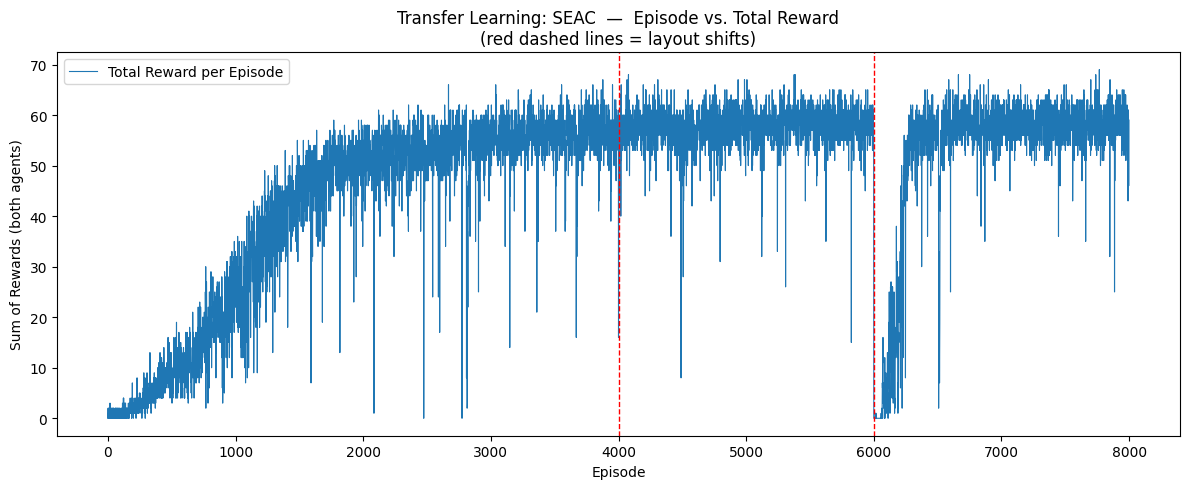

In [ ]:
# =============================================================================
# 5. MAIN DRIVER (chooses which trainer to run, aggregates results, plots)
# =============================================================================

def main(mode: str = "dqn"):
    """
    Set use_dqn = True  → run DQNTrainer over all layout stages.
    Set use_dqn = False → run Q‐table Trainer over all layout stages.
    """
    all_episode_rewards = []
    stage_boundaries    = []
    total_episodes_seen = 0
    shared_net = None
    shared_policy_net = None      # ← add this
    shared_optimizer  = None
    shared_net        = None

    if mode == "dqn":
        if device is None:
            raise RuntimeError("Cannot run DQN mode: PyTorch not installed.")
        shared_memory      = deque(maxlen=replay_capacity)
        shared_policy_net  = None
        shared_target_net  = None
        shared_optimizer   = None
        # New: use a single shared_policy_net & shared_target_net for all agents
        agents = [
            DQNAgent2(i,
                    policy_net=shared_policy_net,    # placeholder for the shared net
                    target_net=shared_target_net,
                    optimizer=shared_optimizer,
                    memory=shared_memory,
                    env=None)                        # placeholder, will be set later
            for i in range(n_agents)
        ]
    elif mode == "seac":
        shared_memory = deque(maxlen=replay_capacity)  # tiny buffer ok
        shared_net    = None
        agents = [SEACAgent(i, shared_net, None, shared_memory, None)
                for i in range(n_agents)]
    else:
        shared_Q = defaultdict(lambda: np.zeros(n_actions))
        agents = [QAgent(i, None, shared_Q) for i in range(n_agents)]

        #agents = [QAgent(i, None) for i in range(n_agents)]
        shared_policy_net = shared_target_net = shared_optimizer = None

    for (layout_name, layout_str, num_eps) in layout_schedule:
        print(f"\n====> TRANSFER STAGE: Layout '{layout_name}', Episodes = {num_eps}")

        if mode == "dqn":
            if shared_policy_net is None:
                temp_env = gym.make("rware:rware-tiny-2ag-v2", layout=layout_str)
                obs0, _ = temp_env.reset()
                obs_dim = np.array(obs0[0]).flatten().shape[0]
                temp_env.close()

                shared_policy_net = DQN(obs_dim, n_actions).to(device)
                shared_target_net = DQN(obs_dim, n_actions).to(device)
                shared_target_net.load_state_dict(shared_policy_net.state_dict())
                shared_optimizer = optim.Adam(shared_policy_net.parameters(), lr=learning_rate)

                for ag in agents:
                    ag.policy_net = shared_policy_net
                    ag.target_net = shared_target_net
                    ag.optimizer  = shared_optimizer

            shared_policy_net, shared_target_net, agents, episode_rewards_log = train_on_layout_dqn(
                layout_name, layout_str, num_eps, agents, shared_policy_net, shared_target_net
            )
        elif mode == "seac":
            shared_net, agents, episode_rewards_log = train_on_layout_seac(
                layout_name, layout_str, num_eps, agents, shared_net
            )
        else:
            agents, episode_rewards_log = train_on_layout_qtable(
                layout_name, layout_str, num_eps, agents
            )

        total_episodes_seen += num_eps
        stage_boundaries.append(total_episodes_seen)
        all_episode_rewards.extend(episode_rewards_log)

        # After training this stage, render and save a GIF
        print(f"▶️  Evaluating & saving GIF for layout '{layout_name}' …")
        evaluate_and_save_gif(layout_name, layout_str, agents, mode,
                          shared_policy_net, shared_net)

    print("\n✅ All transfer‐learning stages complete. Final model is ready.")

    # Plot “Episode vs. Total Reward” with vertical lines at layout shifts
    plt.figure(figsize=(12, 5))
    plt.plot(all_episode_rewards, linewidth=0.8, label="Total Reward per Episode")
    for b in stage_boundaries[:-1]:
        plt.axvline(x=b, color='red', linestyle='--', linewidth=1)
    mode_str = {"dqn": "DQN", "seac": "SEAC", "q": "Q-table"}[mode]
    plt.title(
        f"Transfer Learning: {mode_str}  —  Episode vs. Total Reward\n"
        "(red dashed lines = layout shifts)"
    )
    plt.xlabel("Episode")
    plt.ylabel("Sum of Rewards (both agents)")
    plt.legend()
    plt.tight_layout()
    out_png = f"{mode_str.lower()}_transfer_reward_curve.png"
    plt.savefig(out_png, dpi=150)
    print(f"📈  Saved reward curve: {out_png}")
    plt.show()

if __name__ == "__main__":
    # Set use_dqn=False to run Q-table; True to run DQN
    main(mode="q")